In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx

In [21]:
def load_results(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict(), dict()]
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'testing', m, experiment)
        files = glob.glob(model_dir + "/**/results.csv", recursive = True)
        results[m] = pd.read_csv(files[0])

        # load bird scales
        fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = glob.glob(model_dir + "/**/radar_index.pickle", recursive = True)[0]
        with open(file, 'rb') as f:
            radar_idx[m] = pickle.load(f)
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_fluxes_*.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + "/**/radar_mtr_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att, radar_idx

In [22]:
def load_results_new(models, experiments, base_dir):
    results = dict()
    bird_scales = dict()
    fluxes = [dict(), dict(), dict()]
    att = dict()
    radar_idx = dict()
    for i, m in enumerate(models):

        experiment = experiments[i]

        # load predictions
        model_dir = osp.join(base_dir, 'training+testing', m, experiment)
        results[m] = pd.read_csv(osp.join(model_dir, 'results.csv'))

        # load bird scales
        fp = osp.join(base_dir, 'training+testing', m, experiment, 'config.yaml')
        with open(fp) as f:
            cfg = load(f, Loader=Loader)
        bird_scales[m] = cfg['datasource']['bird_scale']
        
        file = osp.join(model_dir, 'radar_index.pickle')
        with open(file, 'rb') as f:
            radar_idx[m] = pickle.load(f)
        
        if 'BirdFluxGraphLSTM' in m or m == 'testFluxMLP':
            files = glob.glob(model_dir + "/local_fluxes_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[0][r] = pickle.load(f)
            files = glob.glob(model_dir + "/radar_fluxes_*.pickle", recursive = True)
            print(len(files))
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[1][r] = pickle.load(f)
            files = glob.glob(model_dir + "/radar_mtr_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    fluxes[2][r] = pickle.load(f)
        if m == 'AttentionGraphLSTM':
            files = glob.glob(model_dir + "/attention_weights_*.pickle", recursive = True)
            for r, file in enumerate(files):
                with open(file, 'rb') as f:
                    att[r] = pickle.load(f)
    return results, bird_scales, fluxes, att, radar_idx

In [3]:
def compare_fluxes(radar_index, fluxes_model, fluxes_radar, trial=0, context=0, src=5, dst=6):

    f_model = torch.cat([f[..., 1:] for f in fluxes_model[trial].values()], dim=-1)
    f_model[~radar_index] = np.nan
    f_model[:, ~radar_index] = np.nan
    f_model = (f_model - f_model.permute(1, 0, 2))
    f_radar = torch.cat([f[..., context:-1] for f in fluxes_radar[trial].values()], dim=-1)

    
    idx = np.where(f_model.detach().numpy()!=0)
    diff = (f_model - f_radar).detach().numpy()
    print((diff[idx]**2).mean())
    
    fig, ax = plt.subplots(figsize=(18,5))
    ax.plot(f_radar[src,dst,:].detach().numpy(), label='radar', alpha=0.5)
    ax.plot(f_model[src,dst,:].detach().numpy(), label='model', alpha=0.5)
    ax.legend()

    fig, ax = plt.subplots(figsize=(8,8))
    fr = f_radar.detach().numpy()
    fm = f_model.detach().numpy()
    mask = np.where(np.isfinite(fm))
    ax.scatter(fr.flatten(), fm.flatten(), alpha=0.2)
    ax.set(xlabel='radar fluxes', ylabel='model fluxes');
    return fig

In [4]:
def plot_fluxes(voronoi, G, all_fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM'):

    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in all_fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [5]:
def compare_fluxes_radar(voronoi, G, results, fluxes_model, fluxes_radar, trial=0, encoder=1, context=0, bird_scales={}, m='BirdFluxGraphLSTM', horizon=40):

    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f_radar = torch.cat([f[..., context:context+horizon-1] for f in fluxes_radar[trial].values()], dim=-1)
    f_model = torch.cat([f[..., 1:horizon] for f in fluxes_model[trial].values()], dim=-1)
    print(f_radar.shape, f_model.shape)
    
    with sb.color_palette("Spectral", n_colors=40):
        fig1, ax1 = plt.subplots(figsize=(10,10))
        radars = results[m].radar.unique()
        for i, ri in enumerate(radars):
            for j, rj in enumerate(radars):
                val1 = f_model[j,i,:].detach().numpy().flatten()
                val2 = f_model[i,j,:].detach().numpy().flatten()
                fm = val1 - val2
                fr = f_radar[j,i,:].detach().numpy().flatten()
                if np.nanmean(fm) != 0:
                    boundary1 = ('boundary' in ri) and ('boundary' in rj)
                    boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()

                    if not boundary1 and not boundary2:
                        #G_new.add_edge(j, i, flux=val * bird_scale)
                        sc = ax1.scatter(fr, fm, alpha=0.5, label=f'{ri} - {rj}')

#     pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

#     fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
#     edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

#     node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
#     cmap = cm.get_cmap('viridis')
#     norm = plt.Normalize(0, len(G_new.edges()))
#     edge_colors = cmap(np.arange(len(G_new.edges())))

#     fig2, ax2 = plt.subplots(figsize=(12,8))
#     options = {
#         'arrowsize': 30,
#     }
#     nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=5, ax=ax, 
#             connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
#     ax.set(title='averaged inferred fluxes between radars')
    

    ax1.set(xlabel='radar fluxes', ylabel='model fluxes');
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return fig1

In [6]:
def plot_net_fluxes(voronoi, G, fluxes, results, trial=0, encoder=0, context=0, bird_scales={}, m='BirdFluxGraphLSTM', compute_net=True):
    bird_scale = bird_scales.get(m, 1)
    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    f = torch.cat([f[..., context:] for f in fluxes[trial].values()], dim=-1)
    mask = np.concatenate([results[m].query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(fluxes[trial]))])


    radars = results[m].radar.unique()
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val1 = np.nanmean(f[j,i,mask].detach().numpy()) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask].detach().numpy())
            if compute_net:
                val = val1 - val2
            else:
                val = val1
            #print(val)
            if val != 0:
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                if val > 0 and not boundary1 and not boundary2:
                #if not boundary1 and not boundary2:
#                     print(val, val2)
                    G_new.add_edge(j, i, flux=val)

    pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    norm = plt.Normalize(fluxes.min(), fluxes.max())
    edge_colors = cmap(norm(fluxes))

    fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    ax.set(title='averaged inferred net fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, fig

In [7]:
base_dir = '/home/fiona/birdMigration/results/radar'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
boundary = voronoi.query('boundary == True').radar.values
inner_idx = voronoi.query('boundary == False').index.values

### With fixed boundary radars, with weighted fluxes

In [8]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'fixed_boundary_without_dummy_radars_encoder_weighted_fluxes']
results0, bird_scales0, fluxes0, _, _ = load_results(models, experiments, base_dir)

5


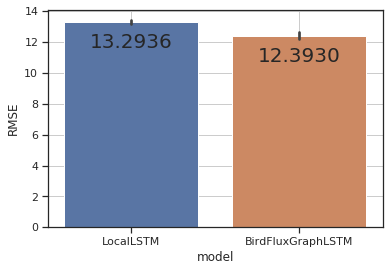

In [98]:
fig = utils.plot_average_errors(results0, boundary=boundary, night_only=True)

In [167]:
1e-7*(1.33**25)

0.00012482196759580874

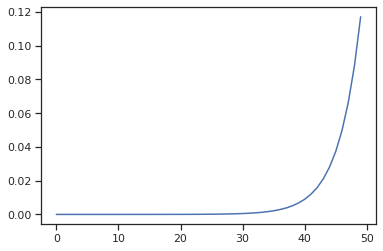

In [164]:
plt.plot([1e-7*(1.33**n) for n in range(50)])

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


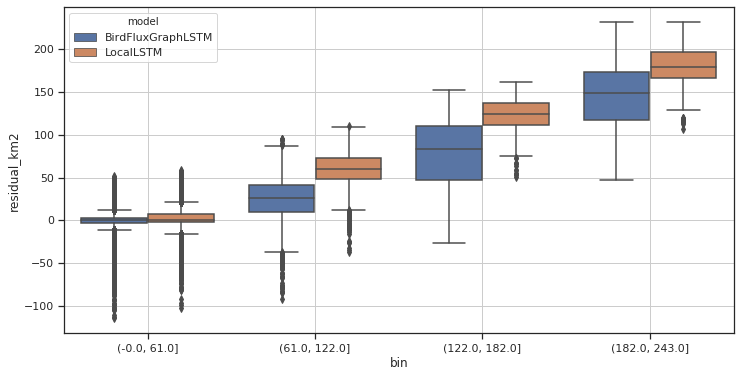

In [152]:
model = 'BirdFluxGraphLSTM'
results = results0
df = results[model].query('missing == False & night == True & gt_km2 > 0 & error != 0')
# df['bin'] = pd.qcut(df.gt_km2, q=8, precision=1)
df['bin'] = pd.cut(df.gt_km2, bins=4, precision=0)
df['model'] = model

model = 'LocalLSTM'
results = results0
df2 = results[model].query(f'missing == False & night == True & gt_km2 > 0 & residual != 0')
df2 = df2[~df2.radar.isin(boundary)]
# df['bin'] = pd.qcut(df.gt_km2, q=4, precision=1)
df2['bin'] = pd.cut(df2.gt_km2, bins=4, precision=0)
df2['model'] = model

df = pd.concat([df, df2])


fig, ax = plt.subplots(figsize=(12, 6))
sb.boxplot(x='bin', y='residual_km2', hue='model', data=df)
plt.grid()

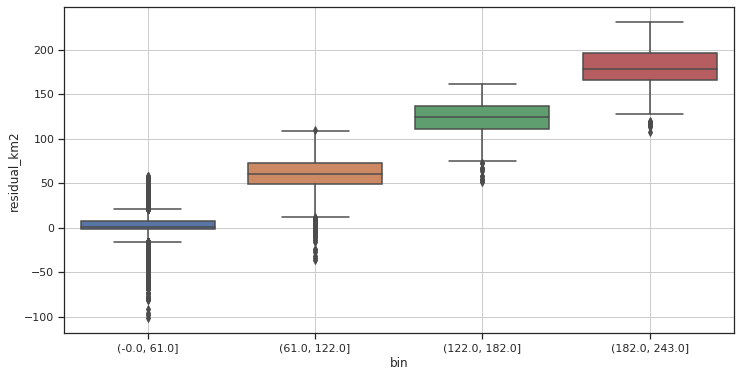

In [150]:
model = 'LocalLSTM'
results = results0
df = results[model].query(f'missing == False & night == True & gt_km2 > 0 & residual != 0')
df = df[~df.radar.isin(boundary)]
# df['bin'] = pd.qcut(df.gt_km2, q=4, precision=1)
df['bin'] = pd.cut(df.gt_km2, bins=4, precision=0)

fig, ax = plt.subplots(figsize=(12, 6))
sb.boxplot(x='bin', y='residual_km2', data=df)
plt.grid()

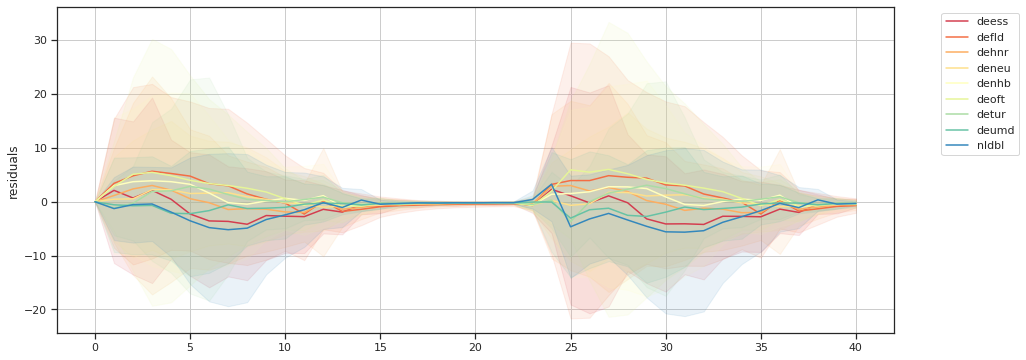

In [163]:
model = 'BirdFluxGraphLSTM'
results = results0
bird_scales={}

df = results[model]
df = df[~df.radar.isin(boundary)]

mean_res = df.groupby(['horizon', 'radar']).residual_km2.aggregate(np.nanmean).reset_index()
std_res = df.groupby(['horizon', 'radar']).residual_km2.aggregate(np.nanstd).reset_index()

with sb.color_palette("Spectral", n_colors=df.radar.unique().size):
    fig, ax = plt.subplots(figsize=(15, 6))
    for r, data in mean_res.groupby(['radar']):
        l = ax.plot(data.horizon.values, data.residual_km2.values, label=r)
        std_df = std_res.query(f'radar == "{r}"')
        ax.fill_between(std_df.horizon.values, data.residual_km2.to_numpy() - std_df.residual_km2.to_numpy(),
                       data.residual_km2.to_numpy() + std_df.residual_km2.to_numpy(), color=l[0].get_color(), alpha=0.1)
    #sb.lineplot(x='horizon', y='error', data=mean_res[['horizon', 'error']], ax=ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    ax.set(ylabel='residuals')

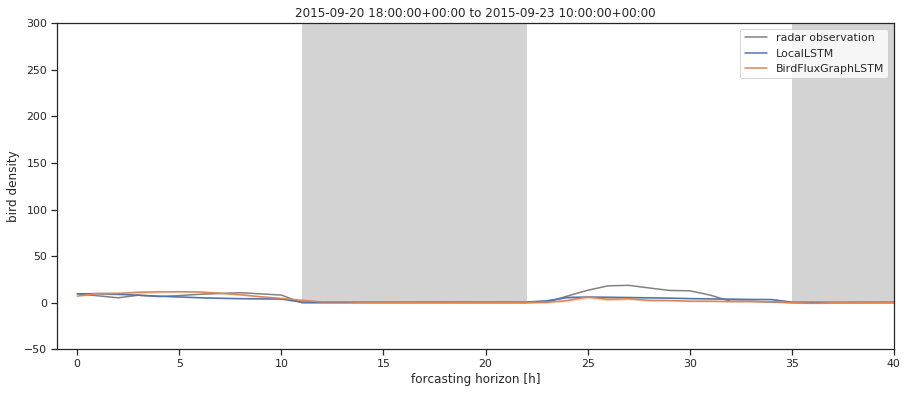

In [77]:
fig = utils.plot_example_prediction(results0, 'defld', 25, max=300, min=-50)

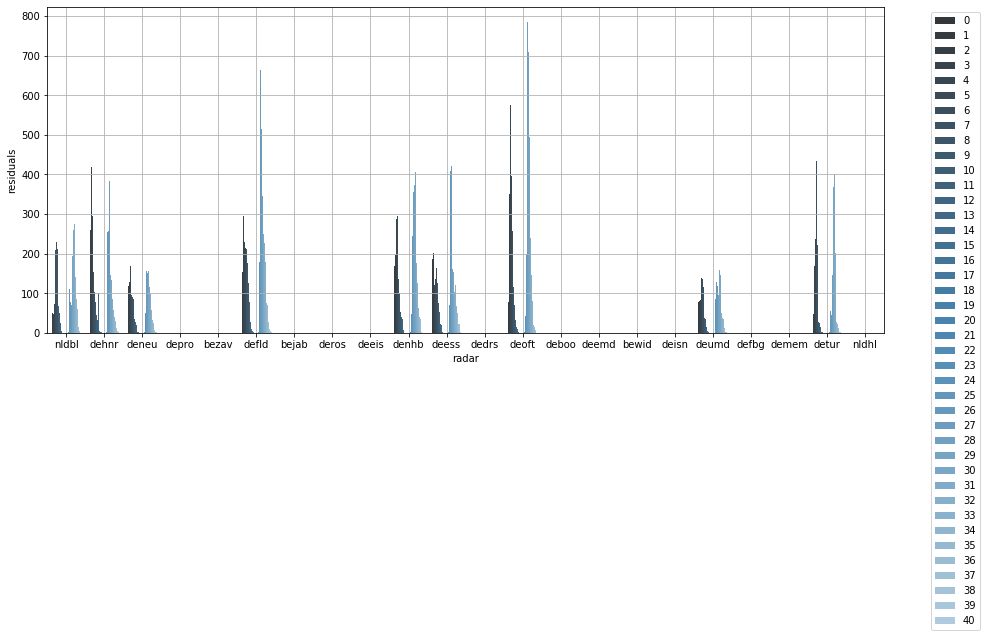

In [9]:
fig = utils.plot_errors_per_radar_and_hour(results0, 'BirdFluxGraphLSTM')

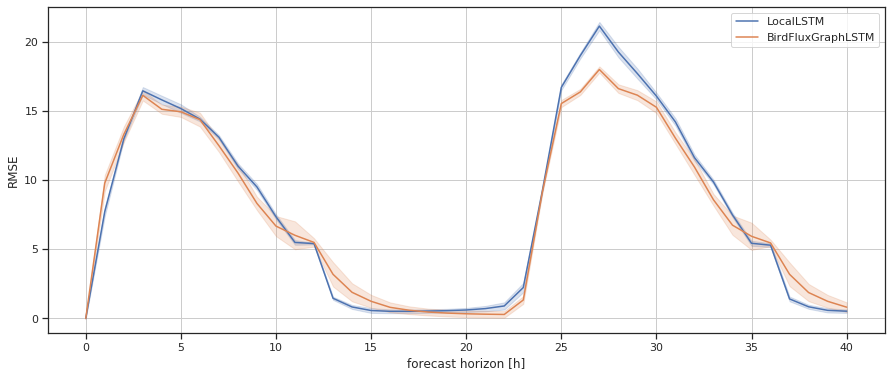

In [322]:
fig = utils.plot_errors(results0, boundary=boundary)

In [13]:
d = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/'
voronoi = gpd.read_file(osp.join(d, 'voronoi.shp'))
static_feature_df = voronoi.drop(columns='geometry')
static_feature_df.to_csv(osp.join(d, 'fig = utils.plot_errors_per_radar_and_hour(results0, 'BirdFluxGraphLSTM').csv'))

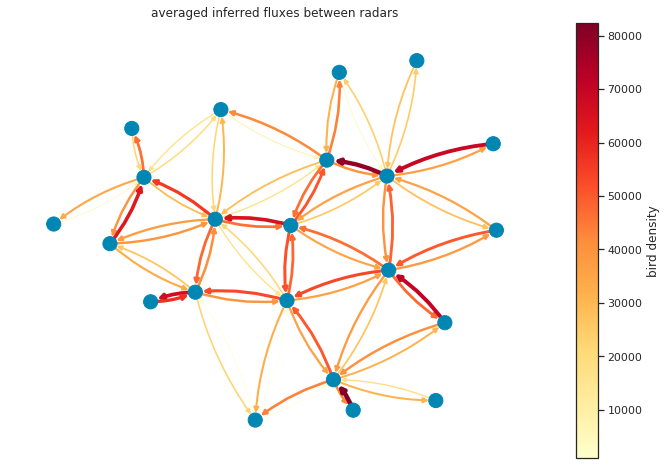

In [304]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scales=bird_scales0)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_fixed_boundary_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

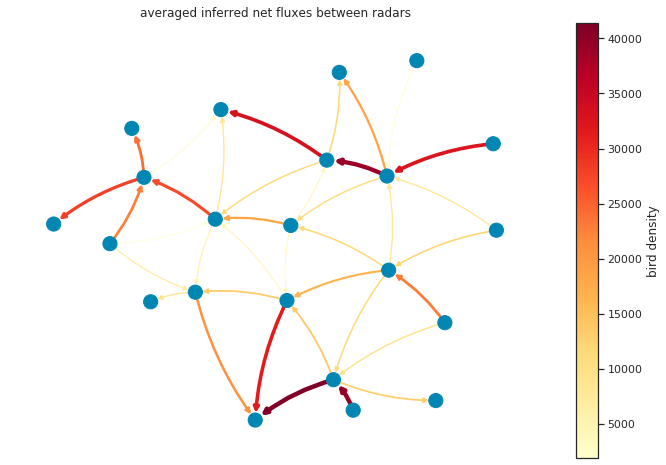

In [313]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_net_fluxes(voronoi, G, fluxes0[0], results0, trial=0, encoder=1, bird_scales=bird_scales0)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/net_fluxes_fixed_boundary_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

nan


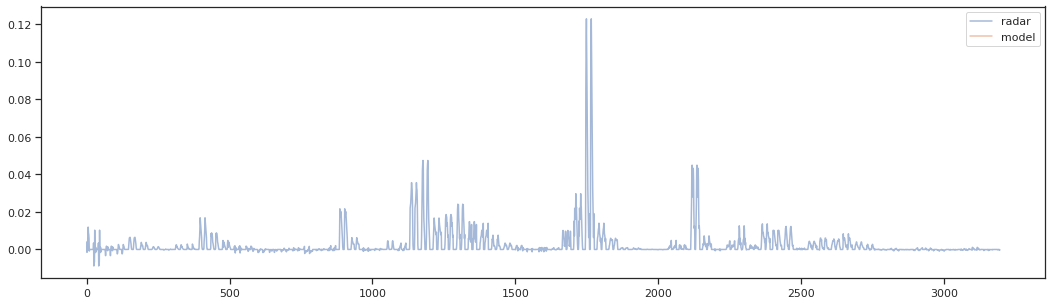

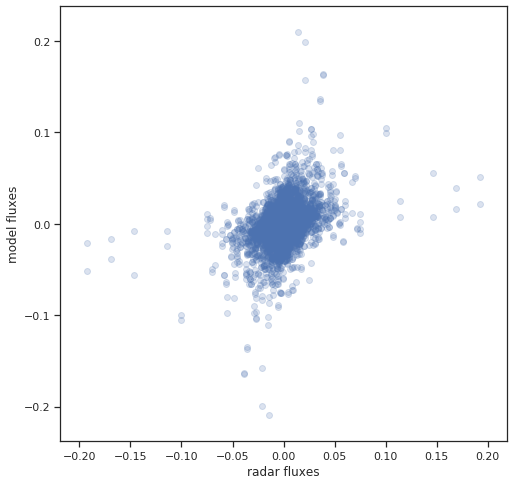

In [301]:
fig = compare_fluxes(inner_radars, fluxes0[0], fluxes0[1], trial=0, context=24, src=10, dst=9)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/scatter_net_fluxes_fixed_boundary_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

torch.Size([22, 22, 3042]) torch.Size([22, 22, 3042])


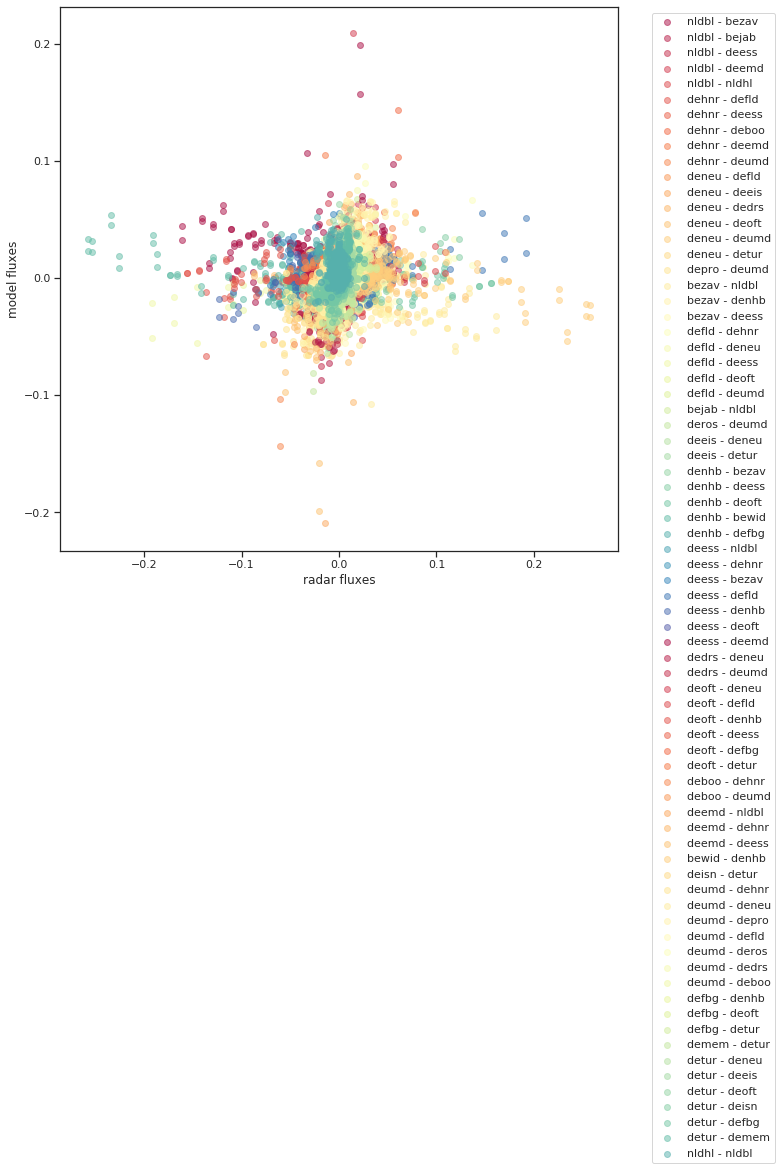

In [53]:
fig = compare_fluxes_radar(voronoi, G_new, results0, fluxes0[0], fluxes0[1], trial=0, encoder=1, 
                           context=24, bird_scales=bird_scales02, m='BirdFluxGraphLSTM', horizon=40)

In [28]:
models = ['BirdFluxGraphLSTM']
#models = ['BirdFluxGraphLSTM']
experiments = [
              'boundary_extrapolation_with_dummy_radars_encoder_batch1_n_hidden64']
results_new, bird_scales_new, fluxes_new, _, _ = load_results_new(models, experiments, base_dir)
results_new['BirdFluxGraphLSTM']['trial'] = 0

0


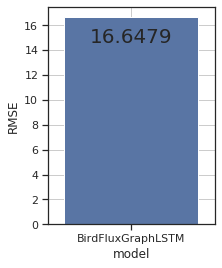

In [29]:
fig = utils.plot_average_errors(results_new, boundary=[], night_only=True, horizon=40)

In [81]:
results[model].columns

Index(['Unnamed: 0', 'gt', 'gt_km2', 'prediction', 'prediction_km2', 'night',
       'radar', 'seqID', 'tidx', 'datetime', 'horizon', 'missing', 'fluxes',
       'local_deltas', 'influxes', 'outfluxes', 'residual', 'residual_km2',
       'trial', 'error'],
      dtype='object')

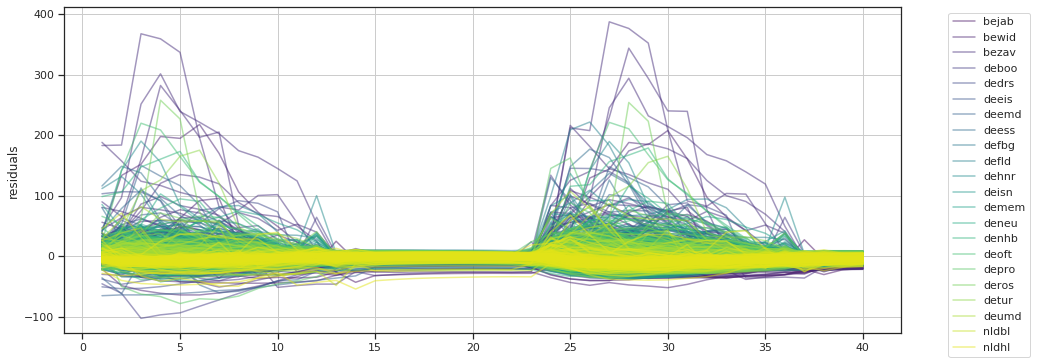

In [90]:
model = 'BirdFluxGraphLSTM'
results = results_new
bird_scales={}

results[model]['error'] = results[model].apply(lambda row: utils.compute_error(row, bird_scales.get(model, 1)),
                                               axis=1)
#mean_res = results[model].groupby(['horizon', 'radar']).error.aggregate(np.nanmean).reset_index()
#print(mean_res)
# mean_mse = mse.groupby('horizon').aggregate(np.nanmean)
# std_mse = mse.groupby('horizon').aggregate(np.nanstd)
df = results[model].query('error != 0 & trial == 0 & missing == False')
# mean_res['radar'] = mean_res.radar.astype("|S")
# mean_res['horizon'] = mean_res.horizon.astype(int)
# mean_res['error'] = mean_res.error.astype(float)
#print(mean_res.dtypes)
with sb.color_palette("viridis", n_colors=df.radar.unique().size):
    fig, ax = plt.subplots(figsize=(15, 6))
    for r, data in df.groupby(['radar']):
        c = None
        for s, d in data.groupby(['seqID']):
            if c is None:
                l = ax.plot(d.horizon.values, d.error.values, label=r, alpha=0.5)
                c = l[0].get_color()
            else:
                ax.plot(d.horizon.values, d.error.values, color=c, alpha=0.5)
    #sb.lineplot(x='horizon', y='error', data=mean_res[['horizon', 'error']], ax=ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    ax.set(ylabel='residuals')

In [94]:
df.gt_km2.describe()

count    52067.000000
mean        11.229403
std         18.900394
min          0.000000
25%          1.512885
50%          5.468092
75%         13.291905
max        421.246770
Name: gt_km2, dtype: float64

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


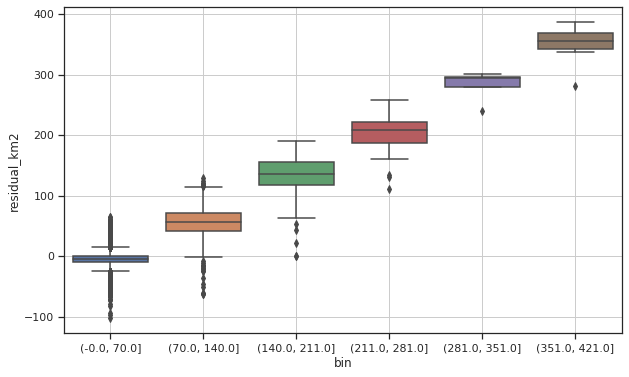

In [108]:
df = results[model].query('trial == 0 & missing == False & night == True & gt_km2 > 0')
# df['bin'] = pd.qcut(df.gt_km2, q=10, precision=1)
df['bin'] = pd.cut(df.gt_km2, bins=6, precision=0)

fig, ax = plt.subplots(figsize=(10, 6))
sb.boxplot(x='bin', y='residual_km2', data=df)
plt.grid()

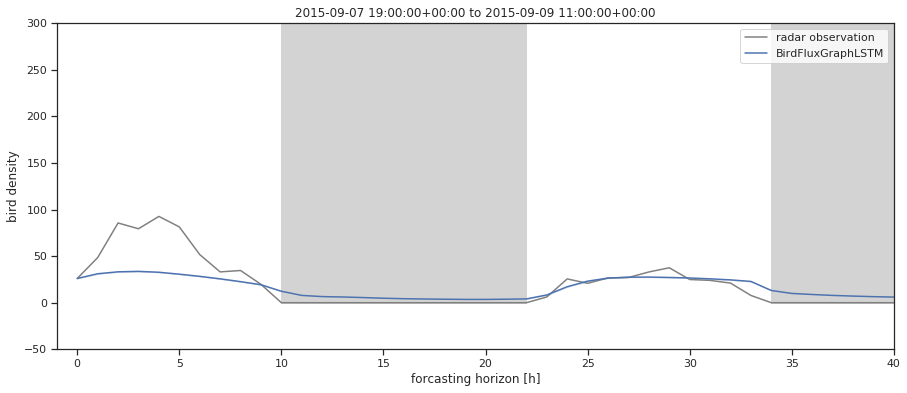

In [36]:
fig = utils.plot_example_prediction(results_new, 'defld', 37, max=300, min=-50)

In [6]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
#models = ['BirdFluxGraphLSTM']
experiments = ['encoder_km2_new',
              'fixed_boundary_without_dummy_radars_encoder_batch1_n_hidden128_no_nights']
results02, bird_scales02, fluxes02, _, _ = load_results(models, experiments, base_dir)

1


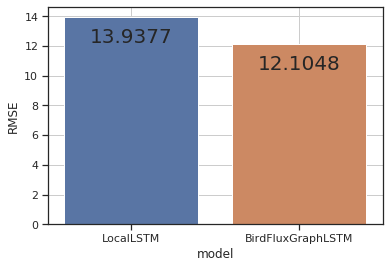

In [27]:
fig = utils.plot_average_errors(results02, boundary=boundary, night_only=True, horizon=40)

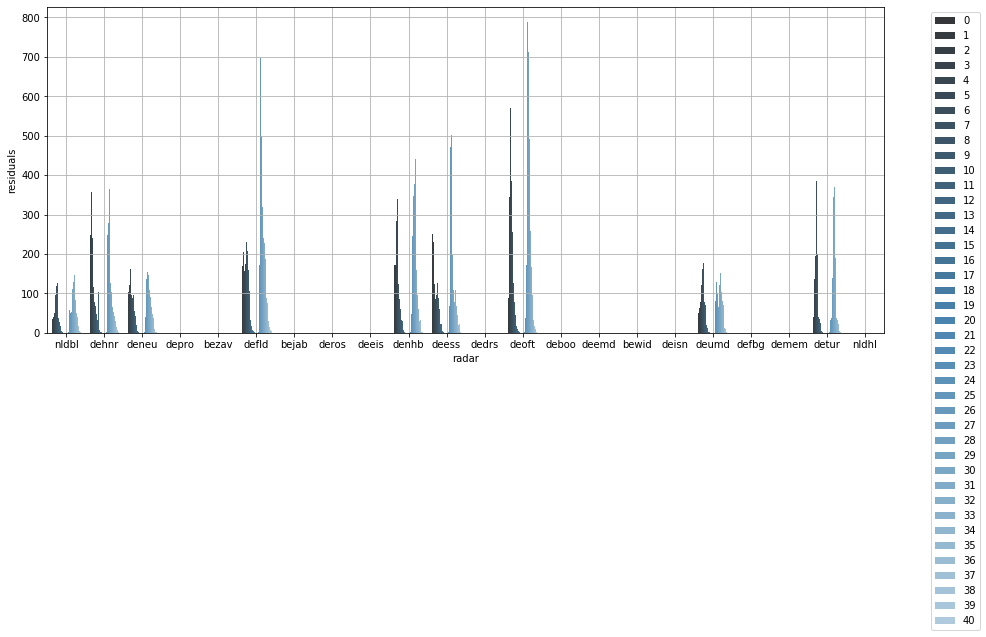

In [7]:
fig = utils.plot_errors_per_radar_and_hour(results02, 'BirdFluxGraphLSTM')

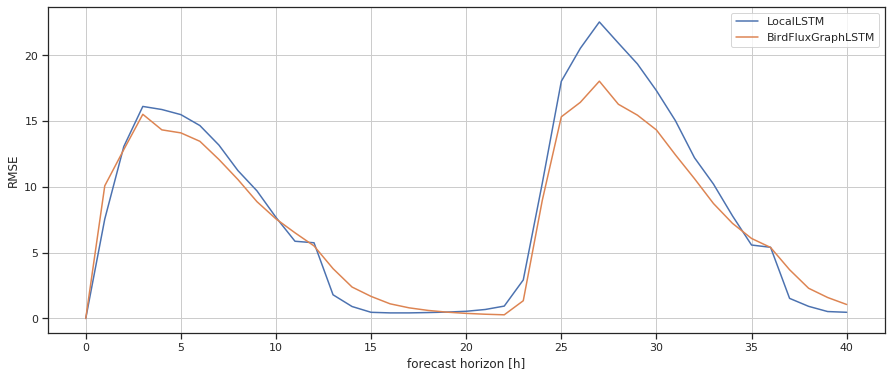

In [28]:
fig = utils.plot_errors(results02, boundary=boundary)

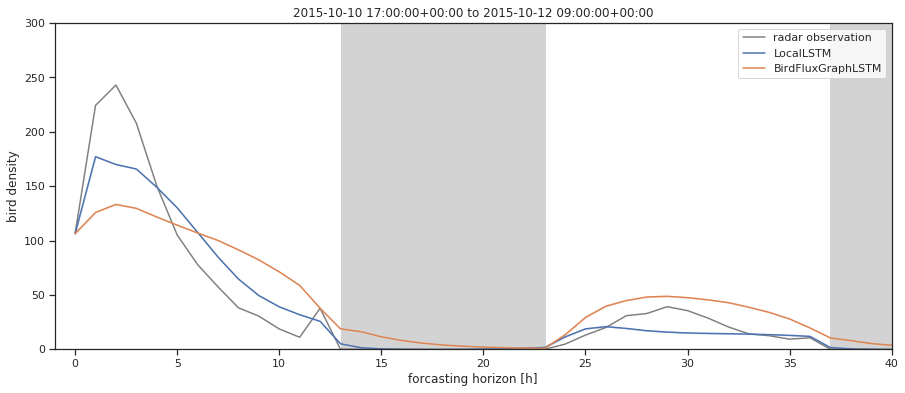

In [29]:
fig = utils.plot_example_prediction(results02, 'defld', 44, max=300)

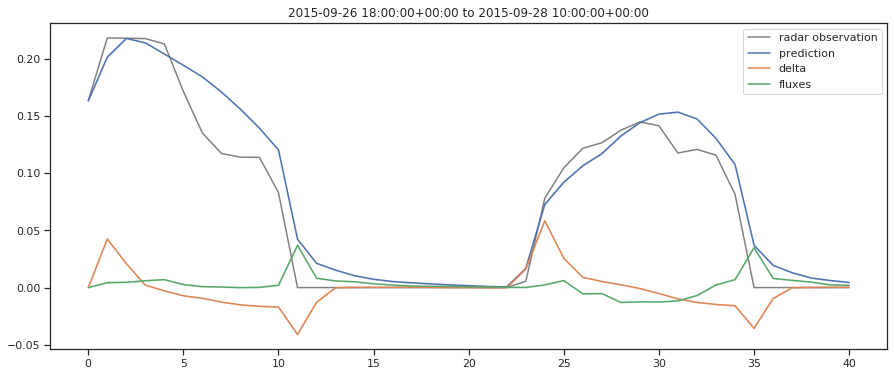

In [30]:
m = 'BirdFluxGraphLSTM'
seqID = 30
radar = 'defld'
fig, ax = plt.subplots(figsize=(15, 6))

r = results02[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales02[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales02[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

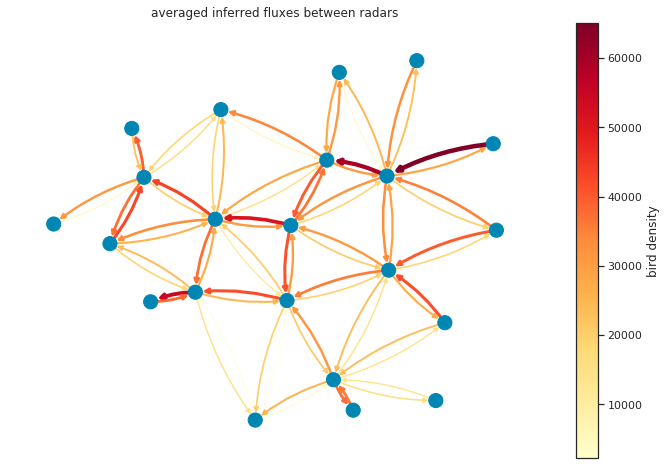

In [31]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes02[0], results02, trial=0, encoder=1, bird_scales=bird_scales02)
#fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_fixed_boundary_weighted_fluxes_contraint0.png', bbox_inches='tight', dpi=300)

nan


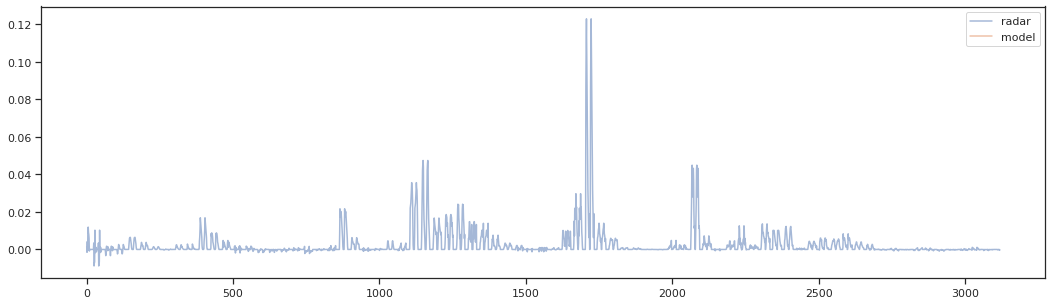

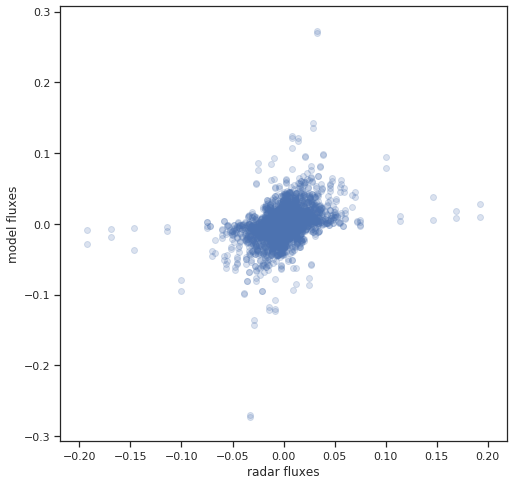

In [36]:
fig = compare_fluxes(inner_radars, fluxes02[0], fluxes02[1], trial=0, context=24, src=10, dst=9)

torch.Size([22, 22, 3042]) torch.Size([22, 22, 3042])


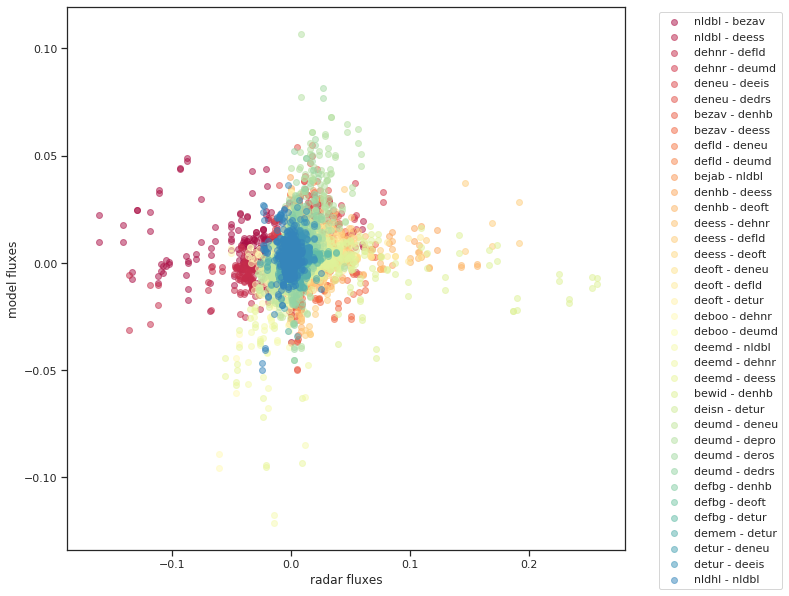

In [46]:
fig = compare_fluxes_radar(voronoi, G_new, results02, fluxes02[0], fluxes02[1], trial=0, encoder=1, 
                           context=24, bird_scales=bird_scales02, m='BirdFluxGraphLSTM', horizon=40)

In [171]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'fixed_boundary_without_dummy_radars_constrained_fluxes10_encoder_weighted_fluxes_batch4']
results01, bird_scales01, fluxes01, _, _ = load_results(models, experiments, base_dir)

1


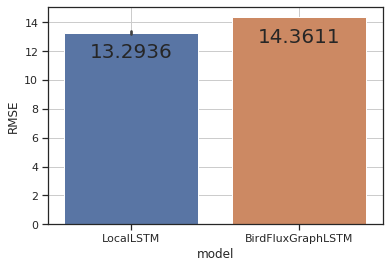

In [172]:
fig = utils.plot_average_errors(results01, boundary=boundary, night_only=True)

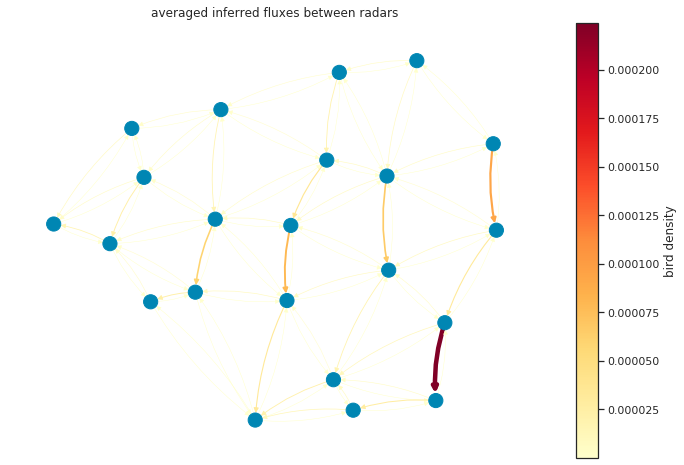

In [173]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes01[0], results01, trial=0, encoder=1, bird_scales=bird_scales01)

(array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,  7,  7,  7,  7,  7,
        9,  9,  9,  9,  9, 10, 10, 10, 13, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16,
       20]), array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 13, 13, 13, 13, 17, 17,
       15, 15, 15, 15, 15,  9,  9,  9,  1,  0,  0, 10, 10, 10, 10, 21, 21,
       21, 

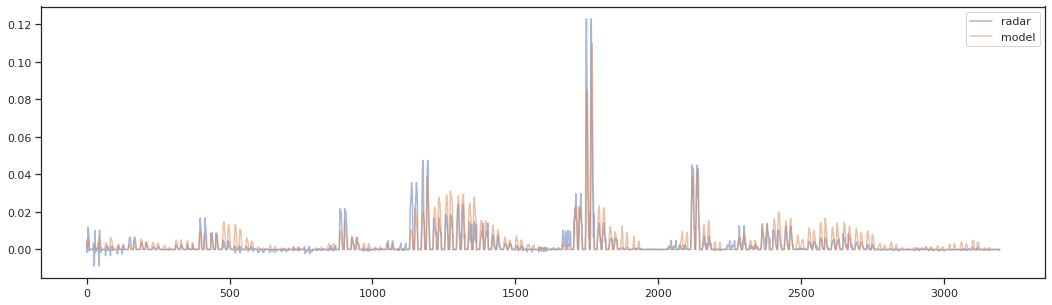

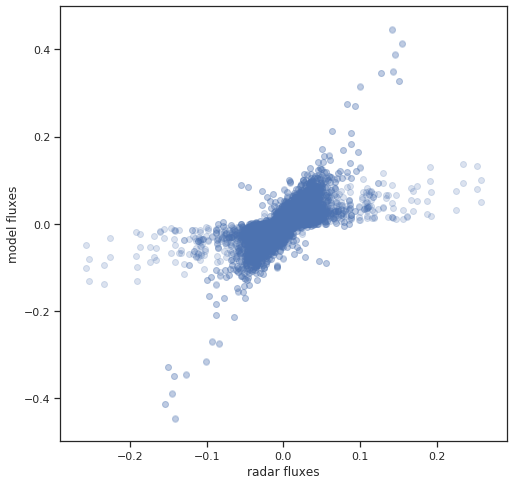

In [147]:
compare_fluxes(voronoi.index.values, fluxes01[0], fluxes01[1], trial=0, context=24, src=10, dst=9)

### Without dummy radars, with weighted fluxes, $c=1.0$

In [201]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_boundary_fluxes1_encoder_weighted_fluxes_batch4']
results1, bird_scales1, fluxes1, _ ,ridx = load_results(models, experiments, base_dir)

1


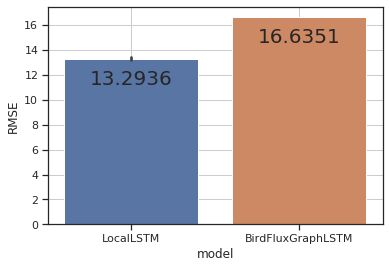

In [185]:
fig = utils.plot_average_errors(results1, boundary=boundary, night_only=True)

In [202]:
ridx

{'LocalLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'},
 'BirdFluxGraphLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'}}

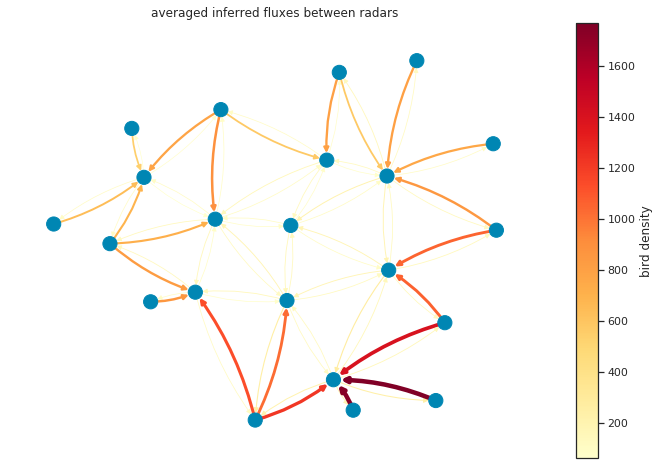

In [187]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes1[0], results1, trial=0, encoder=1, bird_scales=bird_scales1)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


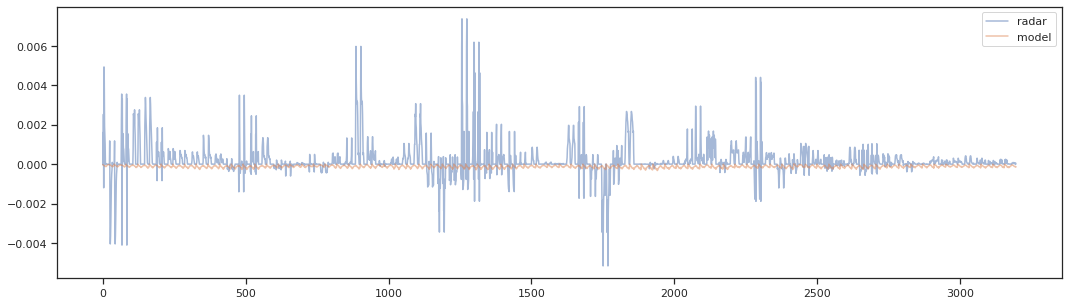

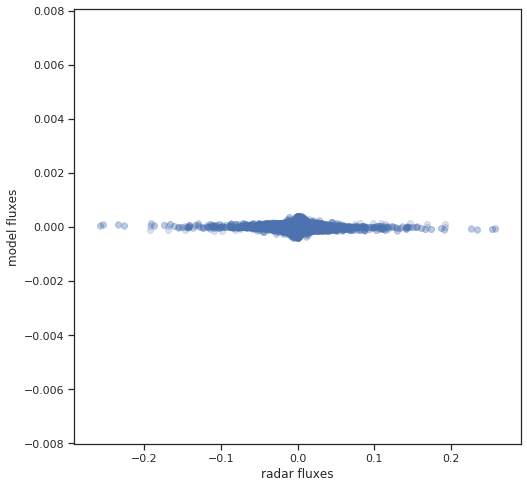

In [204]:
compare_fluxes(voronoi.index.values, fluxes1[0], fluxes1[1], trial=0, context=24, src=9, dst=18)

In [197]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes05_encoder_batch4_n_hidden64']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


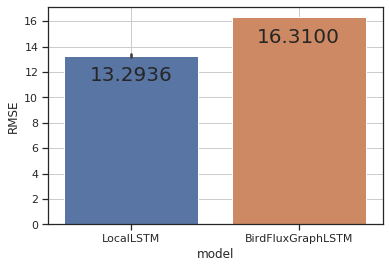

In [199]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

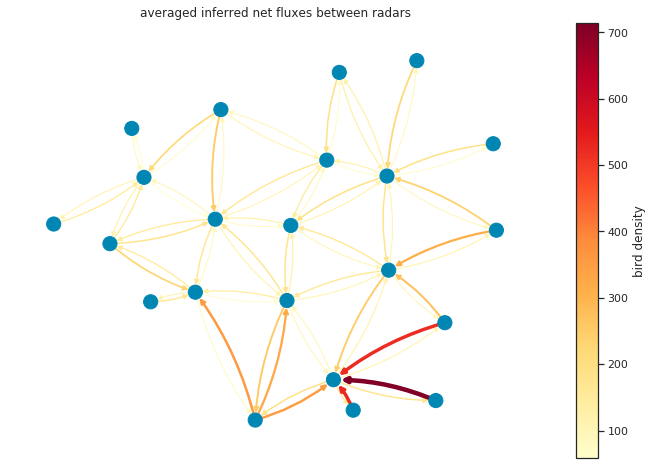

In [198]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_net_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM', compute_net=False)

In [310]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_encoder_batch4_n_hidden128']
results2a, bird_scales2a, fluxes2a, _, ridx2a = load_results(models, experiments, base_dir)

1


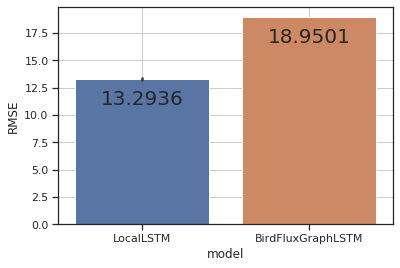

In [311]:
fig = utils.plot_average_errors(results2a, boundary=boundary, night_only=True)

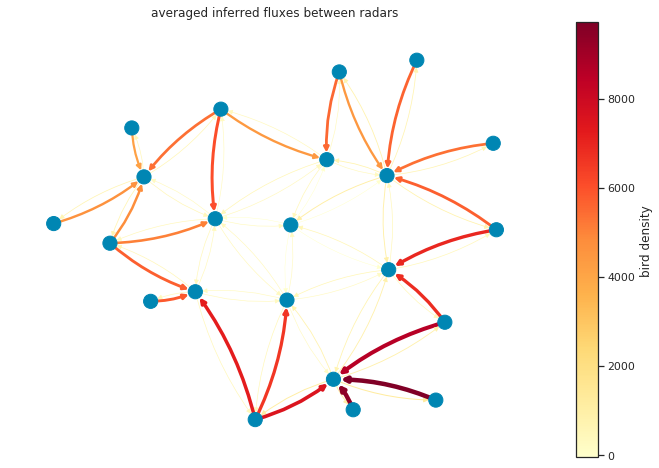

In [312]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes2a[0], results2a, trial=0, encoder=1, bird_scales=bird_scales2a, m='BirdFluxGraphLSTM')

In [307]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes02_encoder_batch4_n_hidden128']
results2a, bird_scales2a, fluxes2a, _, ridx2a = load_results(models, experiments, base_dir)

1


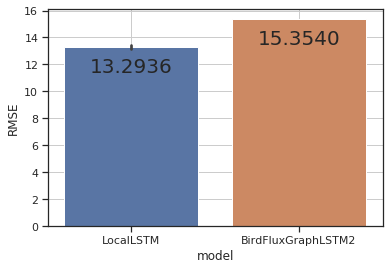

In [308]:
fig = utils.plot_average_errors(results2a, boundary=boundary, night_only=True)

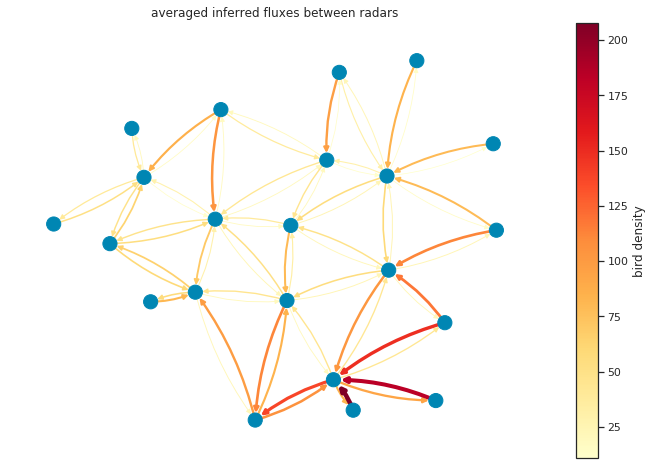

In [309]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes2a[0], results2a, trial=0, encoder=1, bird_scales=bird_scales2a, m='BirdFluxGraphLSTM2')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_mlp_contraint02.png', bbox_inches='tight', dpi=300)

In [314]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes01_encoder_batch4_n_hidden128']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


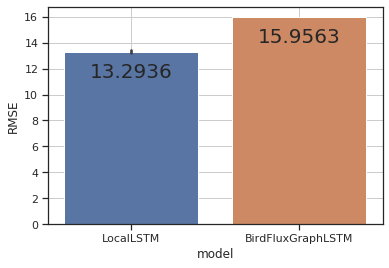

In [286]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

In [287]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

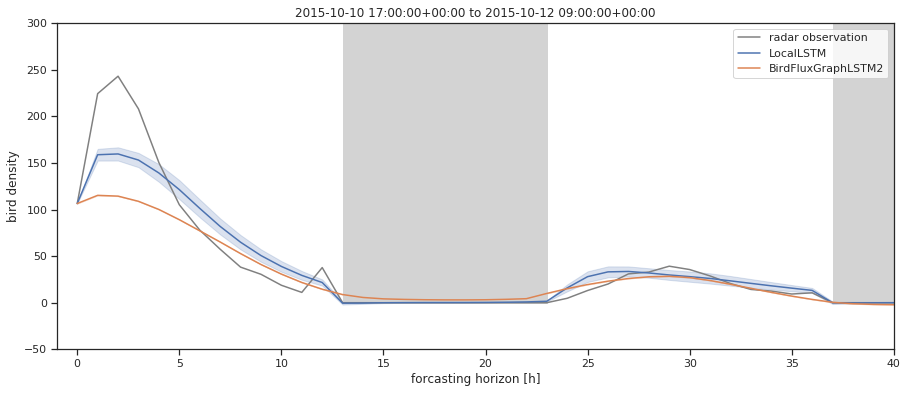

In [305]:
fig = utils.plot_example_prediction(results2, 'defld', 44, max=300, min=-50)

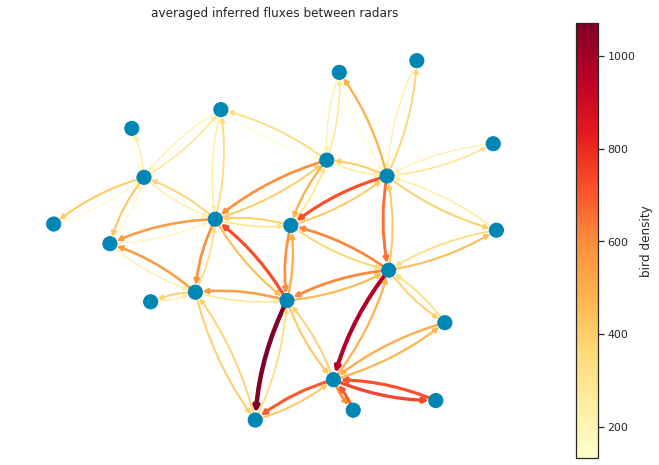

In [290]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

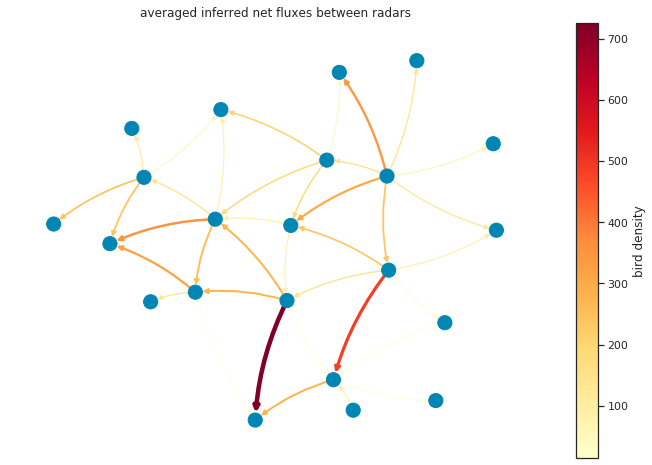

In [315]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_net_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/net_fluxes_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

4.135249032745314e-05


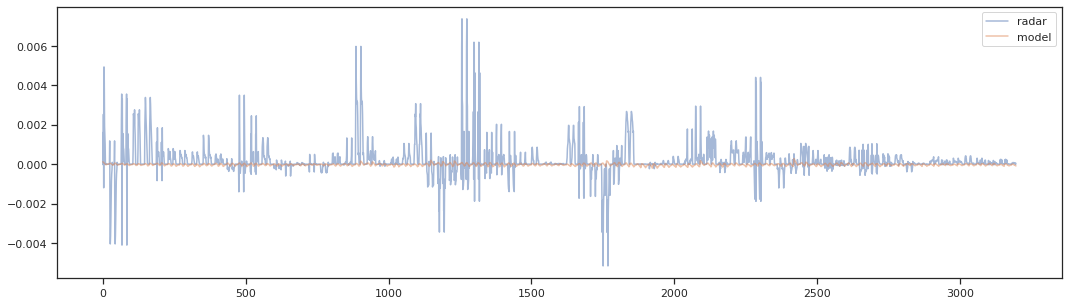

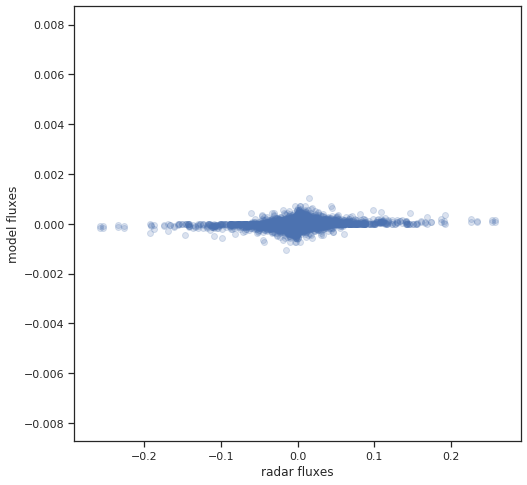

In [292]:
fig = compare_fluxes(voronoi.index.values, fluxes2[0], fluxes2[1], trial=0, context=24, src=9, dst=18)
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/scatter_net_fluxes_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

In [177]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlptanh_without_dummy_radars_constrained_fluxes10_encoder_weighted_fluxes_batch4']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


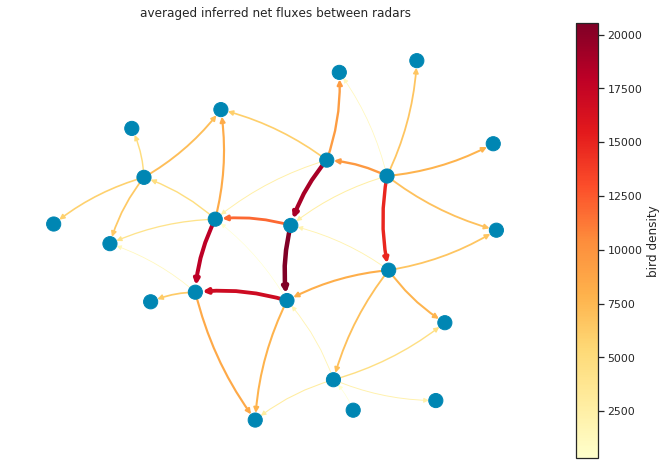

In [179]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_net_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM', compute_net=False)

### Without dummy radars, without weighted fluxes, $c=100.0$

In [293]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes01_encoder_batch4_n_hidden128']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


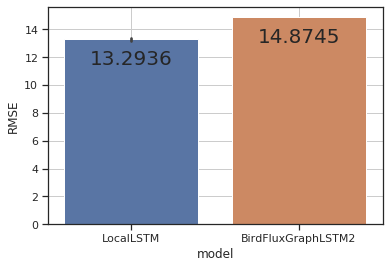

In [294]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

In [295]:
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/performance_boundary_mlp_contraint01.png', bbox_inches='tight', dpi=300)

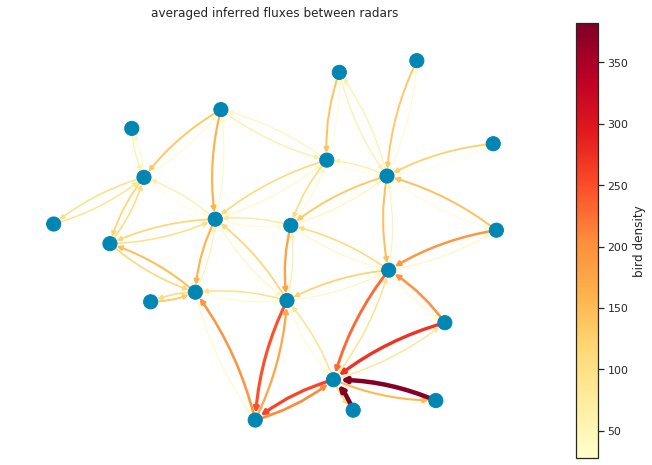

In [296]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new, fig = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM2')
fig.savefig('/home/fiona/birdMigration/data/plots/presentations/fluxes_boundary_mlp_weighted_fluxes_contraint01.png', bbox_inches='tight', dpi=300)

In [165]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_mlp_without_dummy_radars_constrained_fluxes10_encoder_batch4']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


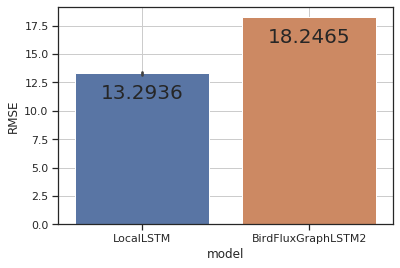

In [166]:
fig = utils.plot_average_errors(results2, boundary=boundary, night_only=True)

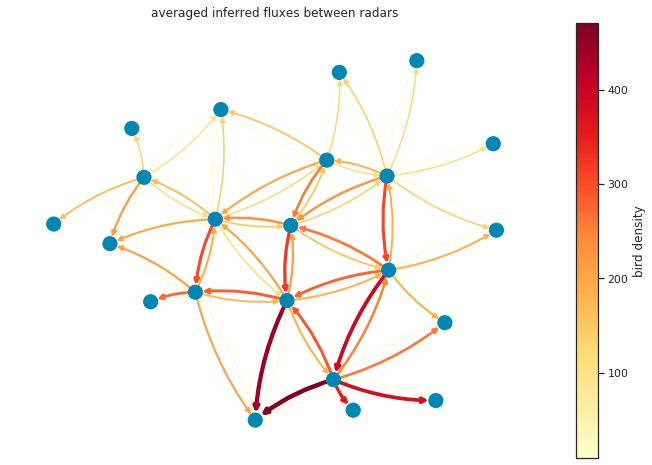

In [167]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='BirdFluxGraphLSTM2')

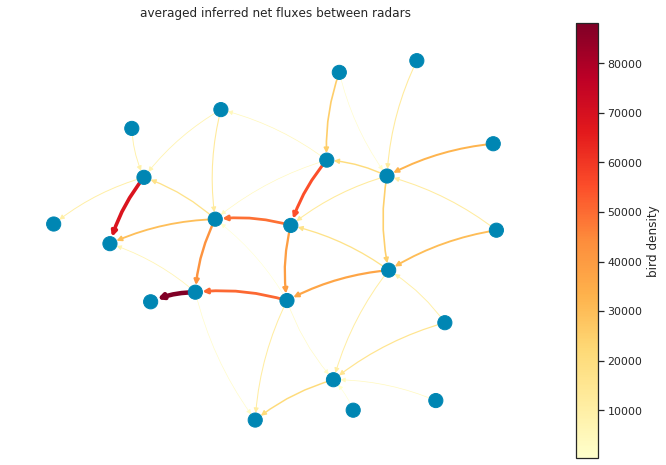

In [163]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_net_fluxes(voronoi, G, fluxes2[1], results2, trial=0, encoder=1, context=24, bird_scales=bird_scales2, m='BirdFluxGraphLSTM2', compute_net=False)

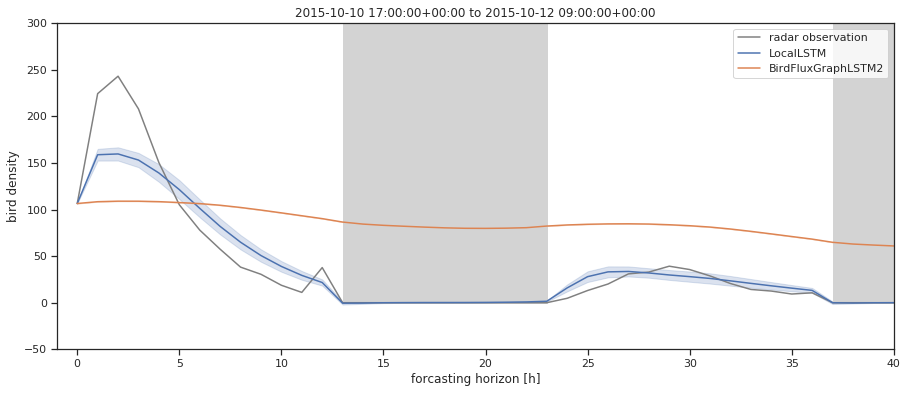

In [191]:
fig = utils.plot_example_prediction(results2, 'defld', 44, max=300, min=-50)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


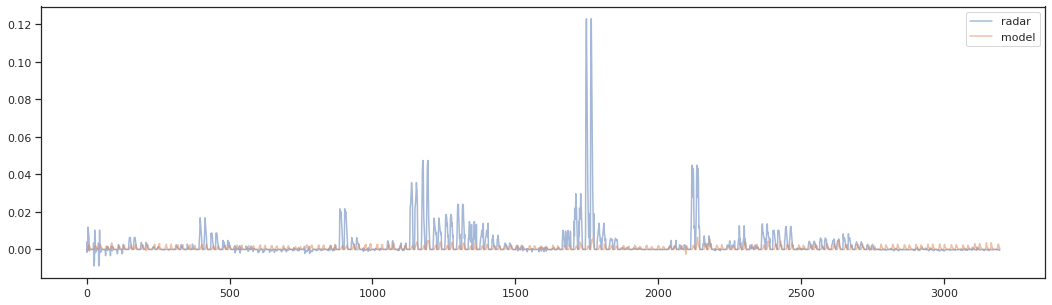

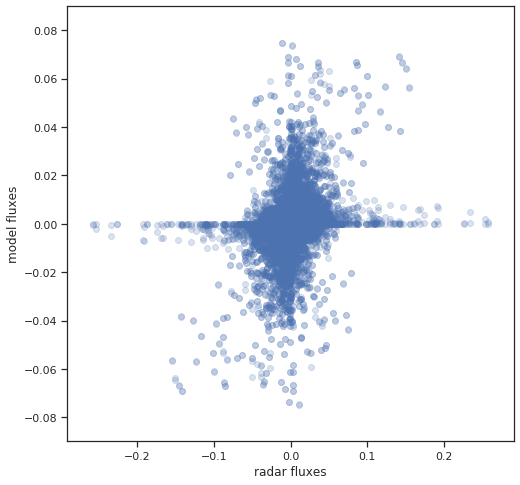

In [136]:
compare_fluxes(voronoi.index.values, fluxes2[0], fluxes2[1], trial=0, context=24, src=10, dst=9)

### With dummy radars, with weighted fluxes, $c=0$

In [320]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = ['encoder_km2',
              'boundary_mlp_with_dummy_radars_encoder_batch1_n_hidden64_new']
results3, bird_scales3, fluxes3, _, _ = load_results(models, experiments, base_dir)

4


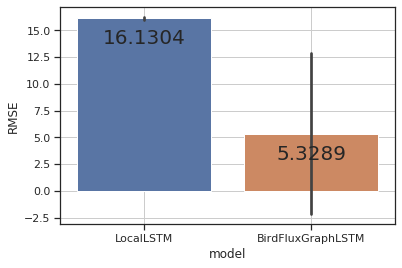

In [321]:
fig = utils.plot_average_errors(results3, boundary=[], night_only=True)

In [319]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes3[0], results3, trial=0, encoder=1, bird_scales=bird_scales3, m='BirdFluxGraphLSTM')

ValueError: zero-size array to reduction operation maximum which has no identity

### With dummy radars, with weighted fluxes, $c=1.0$

In [148]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM2']
experiments = ['encoder_km2',
              'boundary_fluxmlp_with_dummy_radars_constrained_fluxes10_encoder']
results3, bird_scales3, fluxes3, _, _ = load_results(models, experiments, base_dir)

1


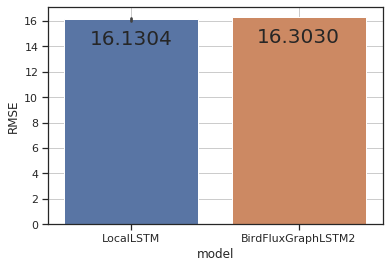

In [149]:
fig = utils.plot_average_errors(results3, boundary=[], night_only=True)

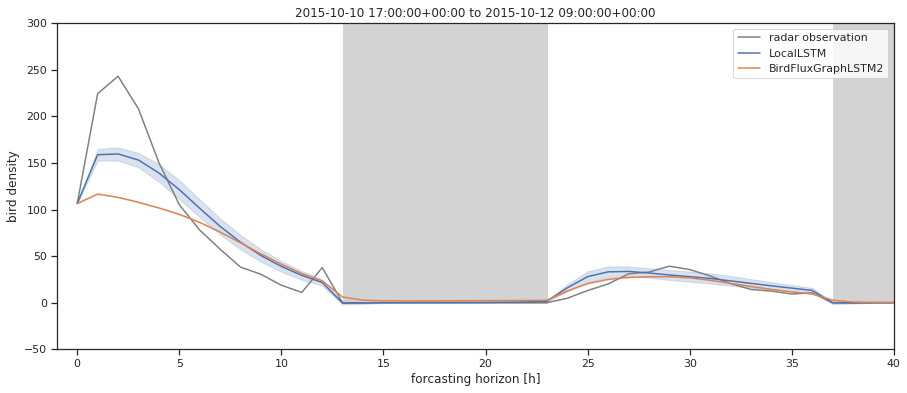

In [154]:
fig = utils.plot_example_prediction(results3, 'defld', 44, max=300, min=-50)

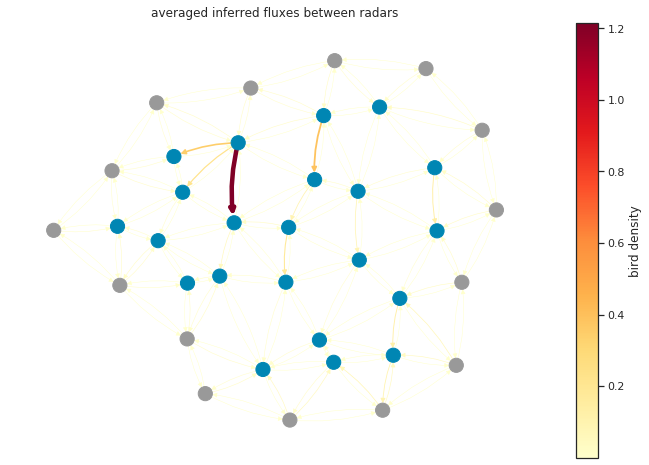

In [151]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes3[0], results3, trial=0, encoder=1, bird_scales=bird_scales3, m='BirdFluxGraphLSTM2')

nldbl bezav -0.010733793947904588 0.010733793947904592
nldbl bejab -0.0007476476333726392 0.0007476476333726391
nldbl deess 0.0027321226196147163 -0.0027321226196147163
nldbl deemd 0.0011664797968285743 -0.0011664797968285743
nldbl nldhl 0.0011495142144352375 -0.001149514214435234
nldbl boundary_0 -0.000945740192185645 0.000945740192185646
dehnr defld -0.008574432907925764 0.008574432907925764
dehnr deess -0.0006023749544213362 0.0006023749544213363
dehnr deboo 0.003994369374264542 -0.0039943693742645415
dehnr deemd -0.0007495784052392876 0.0007495784052392907
dehnr deumd 0.0032653458708152864 -0.003265345870815287
deneu defld -0.0027530398932298045 0.0027530398932298045
deneu deeis 0.0015700062052968532 -0.0015700062052968536
deneu dedrs 0.004746424466824787 -0.004746424466824787
deneu deoft -0.005834016747553875 0.005834016747553875
deneu deumd 0.003879666722870945 -0.003879666722870945
deneu detur -0.0017002960326816354 0.0017002960326816348
depro deros 0.0015334052437365009 -0.0015

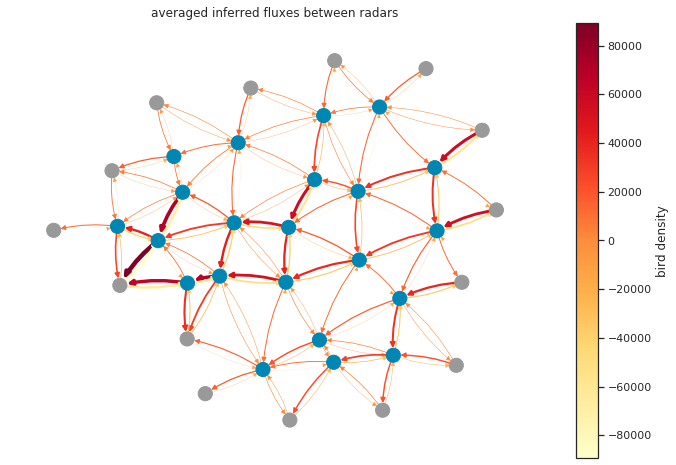

In [21]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes3[1], results3, trial=0, encoder=1, context=24, bird_scale=bird_scales3['BirdFluxGraphLSTM'])

(array([ 0,  0,  0, ..., 36, 36, 36]), array([10, 10, 10, ...,  6,  6,  6]), array([  10,   11,   12, ..., 3194, 3195, 3196]))


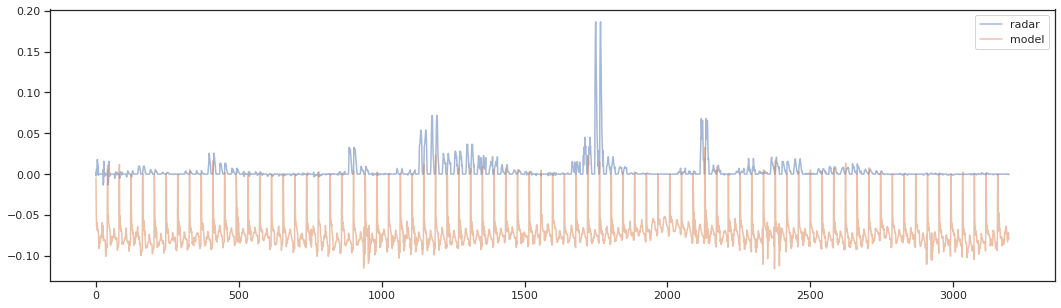

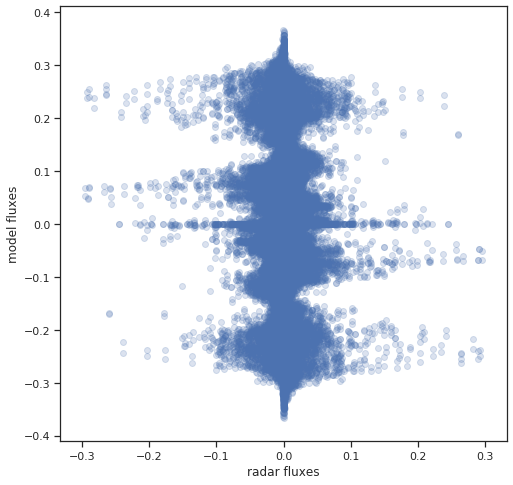

In [129]:
compare_fluxes(voronoi.index.values, fluxes3[0], fluxes3[1], trial=0, context=24, src=10, dst=9)

In [273]:
models = ['LocalLSTM', 'testFluxMLP']
experiments = ['encoder_km2',
              'test_batch4_n_hidden64_x_i']
results2, bird_scales2, fluxes2, _, ridx2 = load_results(models, experiments, base_dir)

1


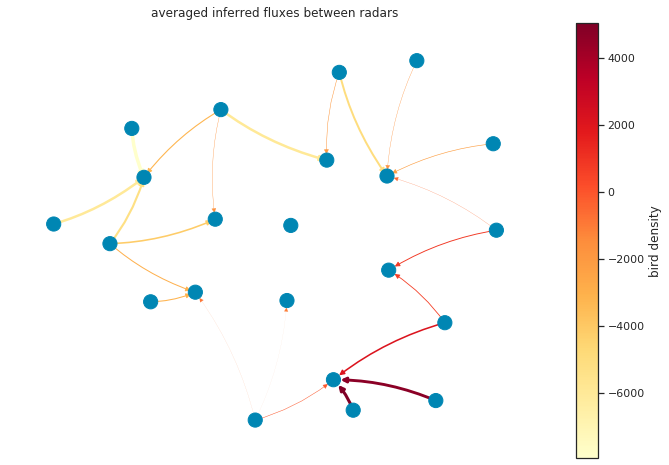

In [274]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2016/voronoi.shp')
inner_radars = voronoi.query('boundary == False').index.values
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2016/delaunay.gpickle'
G = nx.read_gpickle(G_path)

G_new = plot_fluxes(voronoi, G, fluxes2[0], results2, trial=0, encoder=1, bird_scales=bird_scales2, m='testFluxMLP')

In [221]:
ridx

{'LocalLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'},
 'BirdFluxGraphLSTM': {0: 'nldbl',
  1: 'dehnr',
  2: 'deneu',
  3: 'depro',
  4: 'bezav',
  5: 'defld',
  6: 'bejab',
  7: 'deros',
  8: 'deeis',
  9: 'denhb',
  10: 'deess',
  11: 'dedrs',
  12: 'deoft',
  13: 'deboo',
  14: 'deemd',
  15: 'bewid',
  16: 'deisn',
  17: 'deumd',
  18: 'defbg',
  19: 'demem',
  20: 'detur',
  21: 'nldhl'}}

2.849597573506007e-05


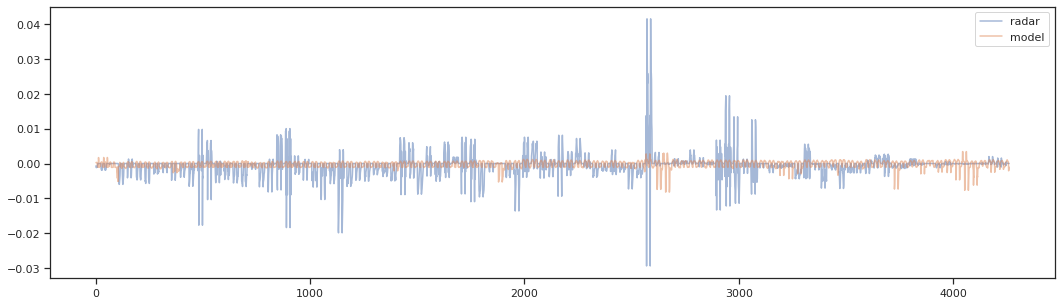

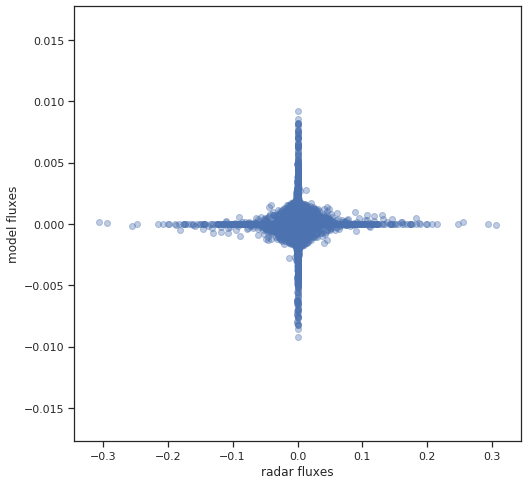

In [277]:
compare_fluxes(voronoi.index.values, fluxes2[0], fluxes2[1], trial=0, context=24, src=19, dst=20)

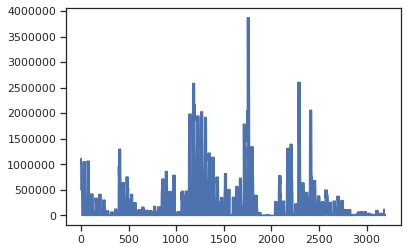

In [257]:
plt.plot(results2['testFluxMLP'].query('radar == "deneu"')['gt'].values)